In [9]:
# =========================
# 1. Import & 경로 설정
# =========================
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import DQN, PPO

# notebooks/ 기준으로 한 단계 위를 프로젝트 루트로 사용
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.env.portfolio_env_discrete import PortfolioEnvDiscrete
from src.env.portfolio_env_continuous import PortfolioEnvContinuous
from src.utils.metrics import performance_stats, nav_from_returns
from src.utils.baselines import equal_weight_returns, buy_and_hold_returns

# 그림 설정
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# 경로 설정
DATA_PATH   = os.path.join(PROJECT_ROOT, "data", "processed", "prices.csv")

RESULTS_DIR        = os.path.join(PROJECT_ROOT, "results")             # DQN
MODELS_DIR         = os.path.join(RESULTS_DIR, "models")
LOGS_DIR           = os.path.join(RESULTS_DIR, "logs")
FIGS_DIR           = os.path.join(RESULTS_DIR, "figures")

RESULTS_CONT_DIR   = os.path.join(PROJECT_ROOT, "results_continuous")  # PPO
MODELS_CONT_DIR    = os.path.join(RESULTS_CONT_DIR, "models")
LOGS_CONT_DIR      = os.path.join(RESULTS_CONT_DIR, "logs")
FIGS_CONT_DIR      = os.path.join(RESULTS_CONT_DIR, "figures")

os.makedirs(FIGS_DIR, exist_ok=True)
os.makedirs(FIGS_CONT_DIR, exist_ok=True)

print("PROJECT_ROOT     :", PROJECT_ROOT)
print("DATA_PATH        :", DATA_PATH)
print("RESULTS_DIR      :", RESULTS_DIR)
print("RESULTS_CONT_DIR :", RESULTS_CONT_DIR)


PROJECT_ROOT     : c:\Users\ohsy1\OneDrive\바탕 화면\RL Assignment\results
DATA_PATH        : c:\Users\ohsy1\OneDrive\바탕 화면\RL Assignment\results\data\processed\prices.csv
RESULTS_DIR      : c:\Users\ohsy1\OneDrive\바탕 화면\RL Assignment\results\results
RESULTS_CONT_DIR : c:\Users\ohsy1\OneDrive\바탕 화면\RL Assignment\results\results_continuous


In [10]:
# =========================
# 2. 데이터 로드 & 분할
# =========================
price_df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
asset_cols = ["SEC", "HYU", "NAVER"]

train_df = price_df.loc[:"2016-12-30"]
valid_df = price_df.loc["2017-01-02":"2019-12-30"]
test_df  = price_df.loc["2020-01-02":]

print("Train :", train_df.index[0], "->", train_df.index[-1], ",", len(train_df))
print("Valid :", valid_df.index[0], "->", valid_df.index[-1], ",", len(valid_df))
print("Test  :", test_df.index[0],  "->", test_df.index[-1],  ",", len(test_df))

Train : 2010-01-01 00:00:00 -> 2016-12-30 00:00:00 , 2556
Valid : 2017-01-02 00:00:00 -> 2019-12-30 00:00:00 , 1093
Test  : 2020-01-02 00:00:00 -> 2025-11-26 00:00:00 , 2156


In [11]:
# =========================
# 3. Validation / Test 성과 테이블 로드
# =========================

# DQN (Discrete)
valid_log_path_dqn = os.path.join(LOGS_DIR, "validation_results.csv")
test_log_path_dqn  = os.path.join(LOGS_DIR, "test_results.csv")

df_valid_dqn = pd.read_csv(valid_log_path_dqn, index_col=0)
df_test_dqn  = pd.read_csv(test_log_path_dqn, index_col=0)

print("=== DQN Validation performance (per seed) ===")
display(df_valid_dqn.style.format("{:.3f}"))

print("=== DQN Test performance (RL vs Baselines) ===")
display(df_test_dqn.style.format("{:.3f}"))

# PPO (Continuous)
valid_log_path_ppo = os.path.join(LOGS_CONT_DIR, "validation_results_ppo.csv")
test_log_path_ppo  = os.path.join(LOGS_CONT_DIR, "test_results_ppo.csv")

df_valid_ppo = pd.read_csv(valid_log_path_ppo, index_col=0)
df_test_ppo  = pd.read_csv(test_log_path_ppo, index_col=0)

print("=== PPO Validation performance (per seed) ===")
display(df_valid_ppo.style.format("{:.3f}"))

print("=== PPO Test performance (RL vs Baselines) ===")
display(df_test_ppo.style.format("{:.3f}"))

=== DQN Validation performance (per seed) ===


,CAGR,Vol,Sharpe,MDD
seed,,,,
0,-0.024,0.169,-0.059,-0.429
42,0.073,0.176,0.489,-0.320
2024,0.077,0.177,0.508,-0.320


=== DQN Test performance (RL vs Baselines) ===


,CAGR,Vol,Sharpe,MDD
Strategy,,,,
RL_DQN,0.084,0.223,0.472,-0.416
EW,0.090,0.206,0.521,-0.434
BH,0.074,0.209,0.446,-0.447


=== PPO Validation performance (per seed) ===


,CAGR,Vol,Sharpe,MDD
seed,,,,
0,0.022,0.150,0.220,-0.387
42,0.025,0.151,0.242,-0.372
2024,0.042,0.149,0.348,-0.339


=== PPO Test performance (RL vs Baselines) ===


,CAGR,Vol,Sharpe,MDD
Strategy,,,,
RL_PPO_CONT,0.059,0.208,0.380,-0.440
EW,0.090,0.206,0.521,-0.434
BH,0.074,0.209,0.446,-0.447


In [12]:
# =========================
# 4. Helper 함수 정의
# =========================

def run_policy_on_env_nav_dqn(model, env: PortfolioEnvDiscrete) -> pd.Series:
    """
    DQN 정책을 주어진 환경에서 한 번 전체 구간 실행하고,
    NAV 시계열을 반환하는 함수이다.
    
    env.step()의 info["nav"]는 거래비용까지 반영된 NAV이다.
    """
    obs, info = env.reset()
    navs = [info.get("nav", 1.0)]

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        if "nav" in info:
            navs.append(info["nav"])

        if terminated or truncated:
            break

    return pd.Series(navs, name="NAV")


def run_policy_on_env_nav_ppo(model, env: PortfolioEnvContinuous) -> pd.Series:
    """
    PPO continuous 정책을 주어진 환경에서 한 번 전체 구간 실행하고,
    NAV 시계열을 반환하는 함수이다.
    """
    obs, info = env.reset()
    navs = [info.get("nav", 1.0)]

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        if "nav" in info:
            navs.append(info["nav"])

        if terminated or truncated:
            break

    return pd.Series(navs, name="NAV")

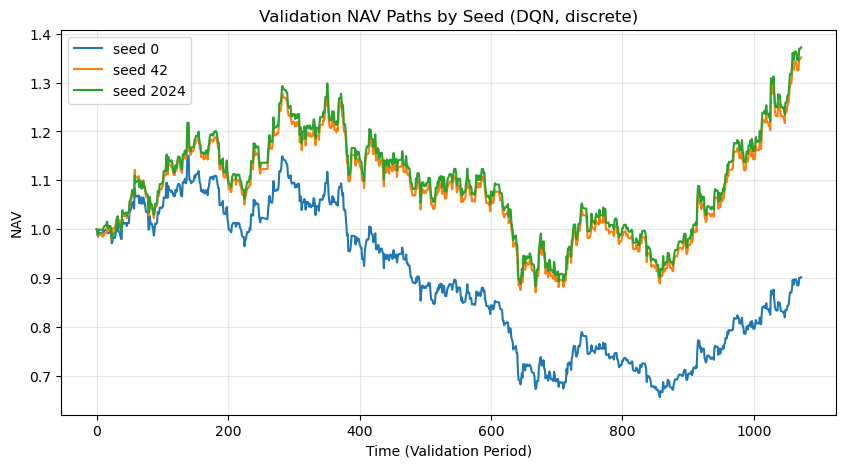

In [13]:
# =========================
# 5. DQN: Validation NAV Paths by Seed
# =========================
seeds = [0, 42, 2024]
nav_paths_dqn = {}

for seed in seeds:
    model_path = os.path.join(MODELS_DIR, f"dqn_seed_{seed}.zip")
    if not os.path.exists(model_path):
        print(f"Missing DQN model: {model_path}")
        continue

    model = DQN.load(model_path)

    env_valid_dqn = PortfolioEnvDiscrete(
        price_df=valid_df,
        asset_cols=asset_cols,
        window_size=20,
        trading_cost=0.002,
        dd_penalty=0.5,
        trade_frac=0.1,
        max_weight=0.5,
        turn_penalty=0.001,
        initial_nav=1.0,
    )

    navs = run_policy_on_env_nav_dqn(model, env_valid_dqn)
    nav_paths_dqn[seed] = navs

plt.figure(figsize=(10, 5))
for seed, navs in nav_paths_dqn.items():
    plt.plot(navs.values, label=f"seed {seed}")
plt.title("Validation NAV Paths by Seed (DQN, discrete)")
plt.xlabel("Time (Validation Period)")
plt.ylabel("NAV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

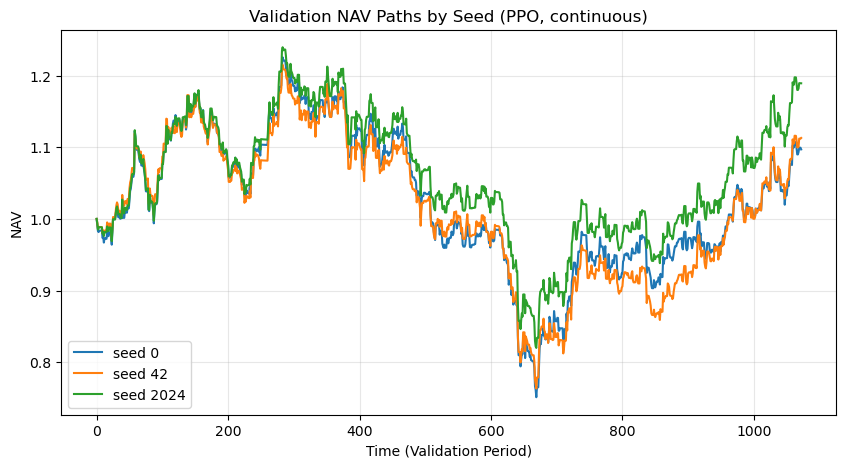

In [14]:
# =========================
# 6. PPO: Validation NAV Paths by Seed
# =========================
nav_paths_ppo = {}

for seed in seeds:
    model_path = os.path.join(MODELS_CONT_DIR, f"ppo_cont_seed_{seed}.zip")
    if not os.path.exists(model_path):
        print(f"Missing PPO model: {model_path}")
        continue

    model = PPO.load(model_path)

    env_valid_ppo = PortfolioEnvContinuous(
        price_df=valid_df,
        asset_cols=asset_cols,
        window_size=20,
        trading_cost=0.002,
        dd_penalty=0.3,
        turn_penalty=0.0005,
        max_weight=0.5,
        initial_nav=1.0,
    )

    navs = run_policy_on_env_nav_ppo(model, env_valid_ppo)
    nav_paths_ppo[seed] = navs

plt.figure(figsize=(10, 5))
for seed, navs in nav_paths_ppo.items():
    plt.plot(navs.values, label=f"seed {seed}")
plt.title("Validation NAV Paths by Seed (PPO, continuous)")
plt.xlabel("Time (Validation Period)")
plt.ylabel("NAV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


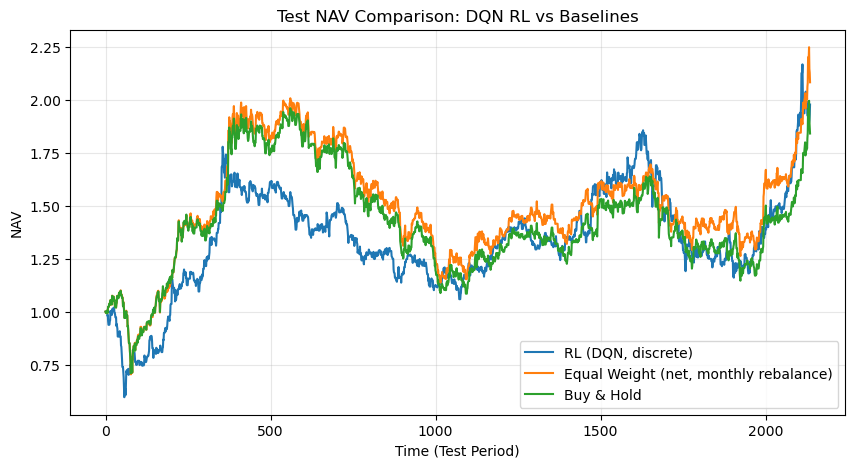

In [15]:
# =========================
# 7. DQN: Test NAV Comparison (RL vs Baselines)
# =========================
best_model_path_dqn = os.path.join(MODELS_DIR, "dqn_best.zip")
model_best_dqn = DQN.load(best_model_path_dqn)

env_test_dqn = PortfolioEnvDiscrete(
    price_df=test_df,
    asset_cols=asset_cols,
    window_size=20,
    trading_cost=0.002,
    dd_penalty=0.5,
    trade_frac=0.1,
    max_weight=0.5,
    turn_penalty=0.001,
    initial_nav=1.0,
)

nav_rl_dqn = run_policy_on_env_nav_dqn(model_best_dqn, env_test_dqn)

# Baseline: Equal Weight는 월별 리밸런싱 + 거래비용 반영 (net 리턴),
# Buy & Hold는 리밸런싱 없음.
ew_ret_test = equal_weight_returns(
    test_df, asset_cols, trading_cost=0.002, rebalance_freq="M"
)
bh_ret_test = buy_and_hold_returns(test_df, asset_cols)

nav_ew_test = nav_from_returns(ew_ret_test)
nav_bh_test = nav_from_returns(bh_ret_test)

min_len = min(len(nav_rl_dqn), len(nav_ew_test), len(nav_bh_test))
x = range(min_len)

plt.figure(figsize=(10, 5))
plt.plot(x, nav_rl_dqn.values[:min_len], label="RL (DQN, discrete)")
plt.plot(x, nav_ew_test.values[:min_len], label="Equal Weight (net, monthly rebalance)")
plt.plot(x, nav_bh_test.values[:min_len], label="Buy & Hold")
plt.title("Test NAV Comparison: DQN RL vs Baselines")
plt.xlabel("Time (Test Period)")
plt.ylabel("NAV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

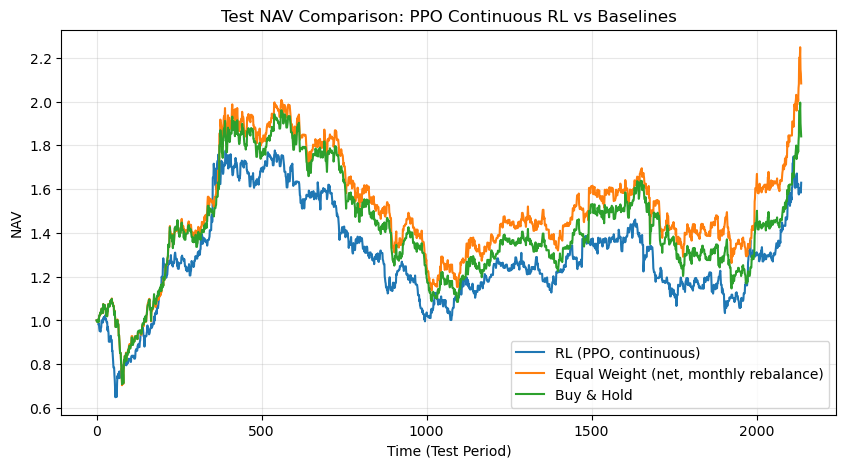

In [16]:
# =========================
# 8. PPO: Test NAV Comparison (RL vs Baselines)
# =========================
best_model_path_ppo = os.path.join(MODELS_CONT_DIR, "ppo_cont_best.zip")
model_best_ppo = PPO.load(best_model_path_ppo)

env_test_ppo = PortfolioEnvContinuous(
    price_df=test_df,
    asset_cols=asset_cols,
    window_size=20,
    trading_cost=0.002,
    dd_penalty=0.3,
    turn_penalty=0.0005,
    max_weight=0.5,
    initial_nav=1.0,
)

nav_rl_ppo = run_policy_on_env_nav_ppo(model_best_ppo, env_test_ppo)

# Baseline은 위에서 계산한 ew_ret_test, bh_ret_test / nav_ew_test, nav_bh_test 재사용 가능
min_len = min(len(nav_rl_ppo), len(nav_ew_test), len(nav_bh_test))
x = range(min_len)

plt.figure(figsize=(10, 5))
plt.plot(x, nav_rl_ppo.values[:min_len], label="RL (PPO, continuous)")
plt.plot(x, nav_ew_test.values[:min_len], label="Equal Weight (net, monthly rebalance)")
plt.plot(x, nav_bh_test.values[:min_len], label="Buy & Hold")
plt.title("Test NAV Comparison: PPO Continuous RL vs Baselines")
plt.xlabel("Time (Test Period)")
plt.ylabel("NAV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

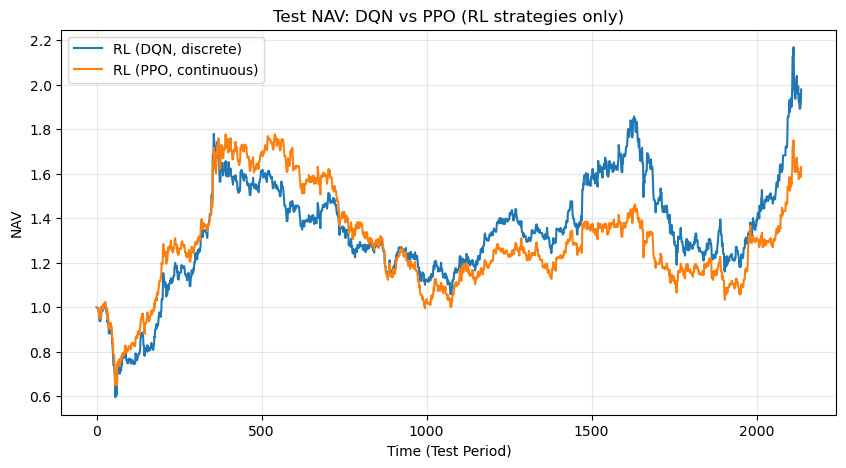

In [17]:
# =========================
# 9. RL 전략끼리 비교: DQN vs PPO
# =========================
min_len_rl = min(len(nav_rl_dqn), len(nav_rl_ppo))
x = range(min_len_rl)

plt.figure(figsize=(10, 5))
plt.plot(x, nav_rl_dqn.values[:min_len_rl], label="RL (DQN, discrete)")
plt.plot(x, nav_rl_ppo.values[:min_len_rl], label="RL (PPO, continuous)")
plt.title("Test NAV: DQN vs PPO (RL strategies only)")
plt.xlabel("Time (Test Period)")
plt.ylabel("NAV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
# =========================
# 10. DQN: NAV & Action 패턴 (Test 구간)
# =========================
def run_policy_with_actions_dqn(model, env: PortfolioEnvDiscrete):
    """
    DQN 정책을 실행하면서 NAV와 discrete action ID를 함께 기록하는 함수이다.
    """
    obs, info = env.reset()
    navs = [info.get("nav", 1.0)]
    actions = []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(int(action))

        obs, reward, terminated, truncated, info = env.step(action)

        if "nav" in info:
            navs.append(info["nav"])

        if terminated or truncated:
            break

    navs = pd.Series(navs, name="NAV")
    actions = pd.Series(actions, name="Action")
    return navs, actions


nav_test_dqn, action_test_dqn = run_policy_with_actions_dqn(model_best_dqn, env_test_dqn)

print(nav_test_dqn.head())
print(action_test_dqn.head())

0    1.000000
1    0.996812
2    0.996484
3    0.996293
4    0.995922
Name: NAV, dtype: float64
0    6
1    6
2    3
3    6
4    1
Name: Action, dtype: int64


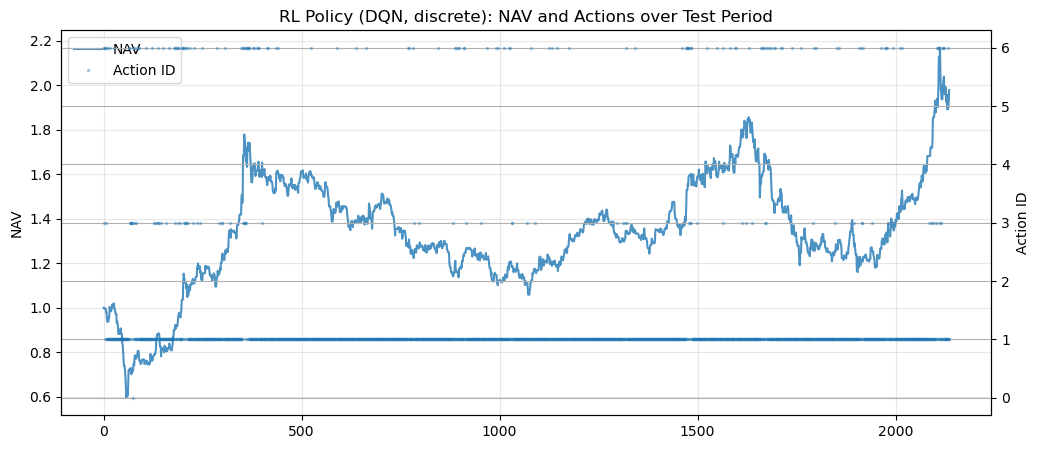

In [19]:
# DQN NAV & Action 시각화
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(nav_test_dqn.values, label="NAV", alpha=0.8)
ax1.set_ylabel("NAV")

ax2 = ax1.twinx()
ax2.plot(action_test_dqn.values, ".", alpha=0.3, label="Action ID", markersize=3)
ax2.set_ylabel("Action ID")

ax1.set_title("RL Policy (DQN, discrete): NAV and Actions over Test Period")
ax1.grid(True, alpha=0.3)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

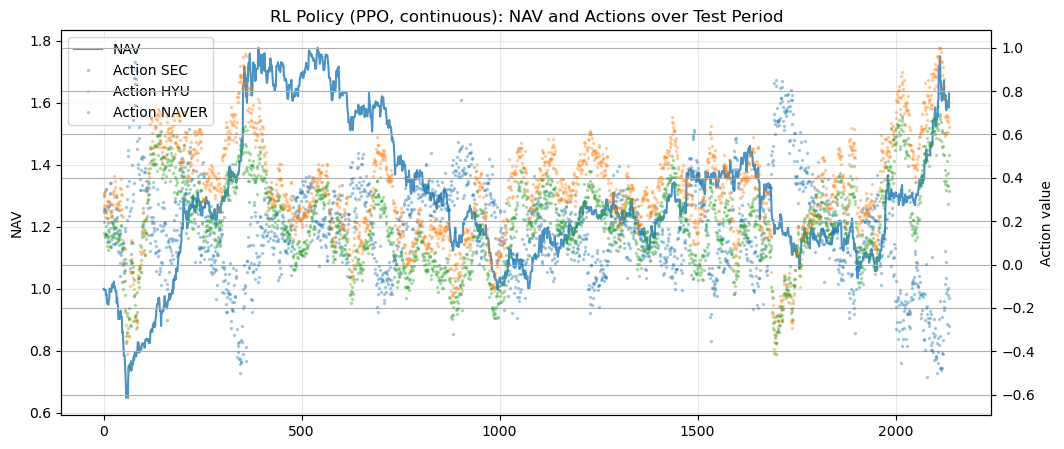

In [20]:
# =========================
# 11. PPO: NAV & Continuous Action 패턴 (선택)
# =========================
def run_policy_with_actions_ppo(model, env: PortfolioEnvContinuous):
    """
    PPO 정책을 실행하면서 NAV와 continuous action 벡터를 함께 기록하는 함수이다.
    """
    obs, info = env.reset()
    navs = [info.get("nav", 1.0)]
    actions = []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action)  # shape (3,)

        obs, reward, terminated, truncated, info = env.step(action)

        if "nav" in info:
            navs.append(info["nav"])

        if terminated or truncated:
            break

    navs = pd.Series(navs, name="NAV")
    actions = np.vstack(actions)  # (T, 3)
    return navs, actions


nav_test_ppo, actions_test_ppo = run_policy_with_actions_ppo(model_best_ppo, env_test_ppo)

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(nav_test_ppo.values, label="NAV", alpha=0.8)
ax1.set_ylabel("NAV")

ax2 = ax1.twinx()
for i, name in enumerate(asset_cols):
    ax2.plot(actions_test_ppo[:, i], ".", alpha=0.3, markersize=3, label=f"Action {name}")
ax2.set_ylabel("Action value")

ax1.set_title("RL Policy (PPO, continuous): NAV and Actions over Test Period")
ax1.grid(True, alpha=0.3)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()